In [1]:
spark

In [2]:
from google.cloud import storage
from pyspark.sql import SparkSession
import os
import pandas as pd
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.functions import *
from pyspark.ml.feature import *
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.ml.regression import *
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import *

In [3]:
#Load data from Google Cloud Storage cleaned folder
cleaned_path = "gs://my-bigdata-project-lh/cleaned/cleaned_data.parquet"
cleaned_df = spark.read.parquet(cleaned_path)


In [4]:
cleaned_df.count()

80918615

In [5]:
cleaned_df.select("baseFare", "seatsRemaining", "totalFare").summary("count", "min", "max", "mean").show()

+-------+-----------------+-----------------+----------------+
|summary|         baseFare|   seatsRemaining|       totalFare|
+-------+-----------------+-----------------+----------------+
|  count|         80918615|         80918615|        80918615|
|    min|             0.01|                0|           19.59|
|    max|           779.75|               10|          830.85|
|   mean|281.6983009873749|5.976206945707116|328.597312795851|
+-------+-----------------+-----------------+----------------+



In [6]:
sampled_df = cleaned_df.sample(withReplacement=False, fraction=0.1)

In [7]:
sampled_df.show(5)
sampled_df.printSchema()
sampled_df.count()

+----------+----------+---------------+------------------+-------------+--------------+------------+---------+--------+---------+--------------+--------------------+-------------------+
|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining| segmentsAirlineName|  segmentsCabinCode|
+----------+----------+---------------+------------------+-------------+--------------+------------+---------+--------+---------+--------------+--------------------+-------------------+
|2022-06-02|2022-06-21|            DFW|               OAK|     QAA0OKEN|         false|       false|    false|  510.69|   577.09|             4|United||United||D...|coach||coach||coach|
|2022-06-02|2022-06-21|            DFW|               OAK|     QAA0OKEN|         false|       false|    false|   529.3|    602.7|             4|United||United||D...|coach||coach||coach|
|2022-06-02|2022-06-21|            DFW|               OAK|     UAA0OKE

8097334

In [8]:
#Calculate Lead Time
sampled_df = sampled_df.withColumn('leadTime', datediff(col('flightDate'), col('searchDate')))

sampled_df.select('searchDate', 'flightDate', 'leadTime').show()


+----------+----------+--------+
|searchDate|flightDate|leadTime|
+----------+----------+--------+
|2022-06-02|2022-06-21|      19|
|2022-06-02|2022-06-21|      19|
|2022-06-02|2022-06-21|      19|
|2022-06-02|2022-06-21|      19|
|2022-06-02|2022-06-21|      19|
|2022-06-02|2022-06-21|      19|
|2022-06-02|2022-06-21|      19|
|2022-06-02|2022-06-21|      19|
|2022-06-02|2022-06-21|      19|
|2022-06-02|2022-06-21|      19|
|2022-06-02|2022-06-21|      19|
|2022-06-02|2022-06-21|      19|
|2022-06-02|2022-06-21|      19|
|2022-06-02|2022-06-21|      19|
|2022-06-02|2022-06-21|      19|
|2022-06-02|2022-06-21|      19|
|2022-06-02|2022-06-21|      19|
|2022-06-02|2022-06-21|      19|
|2022-06-02|2022-06-21|      19|
|2022-06-02|2022-06-21|      19|
+----------+----------+--------+
only showing top 20 rows



In [9]:
sampled_df = sampled_df.withColumn("flight_year", year(col("flightDate")))
sampled_df = sampled_df.withColumn("flight_month", month(col("flightDate")))
sampled_df = sampled_df.withColumn("flight_yearmonth", date_format(col("flightDate"), "yyyy-MM"))
sampled_df = sampled_df.withColumn("flight_dayofweek", date_format(col("flightDate"), "EEEE"))

# Determine if the day is a weekend
sampled_df = sampled_df.withColumn(
    "flight_weekend",
    when(col("flight_dayofweek").isin("Saturday", "Sunday"), 1.0).otherwise(0.0)
)

# Verify the results
sampled_df.select(
    "flightDate", "flight_year", "flight_month",
    "flight_yearmonth", "flight_dayofweek", "flight_weekend"
).show()

+----------+-----------+------------+----------------+----------------+--------------+
|flightDate|flight_year|flight_month|flight_yearmonth|flight_dayofweek|flight_weekend|
+----------+-----------+------------+----------------+----------------+--------------+
|2022-06-21|       2022|           6|         2022-06|         Tuesday|           0.0|
|2022-06-21|       2022|           6|         2022-06|         Tuesday|           0.0|
|2022-06-21|       2022|           6|         2022-06|         Tuesday|           0.0|
|2022-06-21|       2022|           6|         2022-06|         Tuesday|           0.0|
|2022-06-21|       2022|           6|         2022-06|         Tuesday|           0.0|
|2022-06-21|       2022|           6|         2022-06|         Tuesday|           0.0|
|2022-06-21|       2022|           6|         2022-06|         Tuesday|           0.0|
|2022-06-21|       2022|           6|         2022-06|         Tuesday|           0.0|
|2022-06-21|       2022|           6|      

In [10]:
# Extract day of week 
sampled_df = sampled_df.withColumn("day_of_week", dayofweek("flightDate"))
# Extract day of the month
sampled_df = sampled_df.withColumn("day_of_month", dayofmonth("flightDate"))
# Extract month
sampled_df = sampled_df.withColumn("month", month("flightDate"))
# Extract year
sampled_df = sampled_df.withColumn("year", year("flightDate"))
sampled_df = sampled_df.withColumn("is_weekend", when((col("day_of_week") == 7) | (col("day_of_week") == 1), 1).otherwise(0))
sampled_df.select("flightDate", "day_of_week", "day_of_month", "month", "year", "is_weekend").show()

+----------+-----------+------------+-----+----+----------+
|flightDate|day_of_week|day_of_month|month|year|is_weekend|
+----------+-----------+------------+-----+----+----------+
|2022-06-21|          3|          21|    6|2022|         0|
|2022-06-21|          3|          21|    6|2022|         0|
|2022-06-21|          3|          21|    6|2022|         0|
|2022-06-21|          3|          21|    6|2022|         0|
|2022-06-21|          3|          21|    6|2022|         0|
|2022-06-21|          3|          21|    6|2022|         0|
|2022-06-21|          3|          21|    6|2022|         0|
|2022-06-21|          3|          21|    6|2022|         0|
|2022-06-21|          3|          21|    6|2022|         0|
|2022-06-21|          3|          21|    6|2022|         0|
|2022-06-21|          3|          21|    6|2022|         0|
|2022-06-21|          3|          21|    6|2022|         0|
|2022-06-21|          3|          21|    6|2022|         0|
|2022-06-21|          3|          21|   

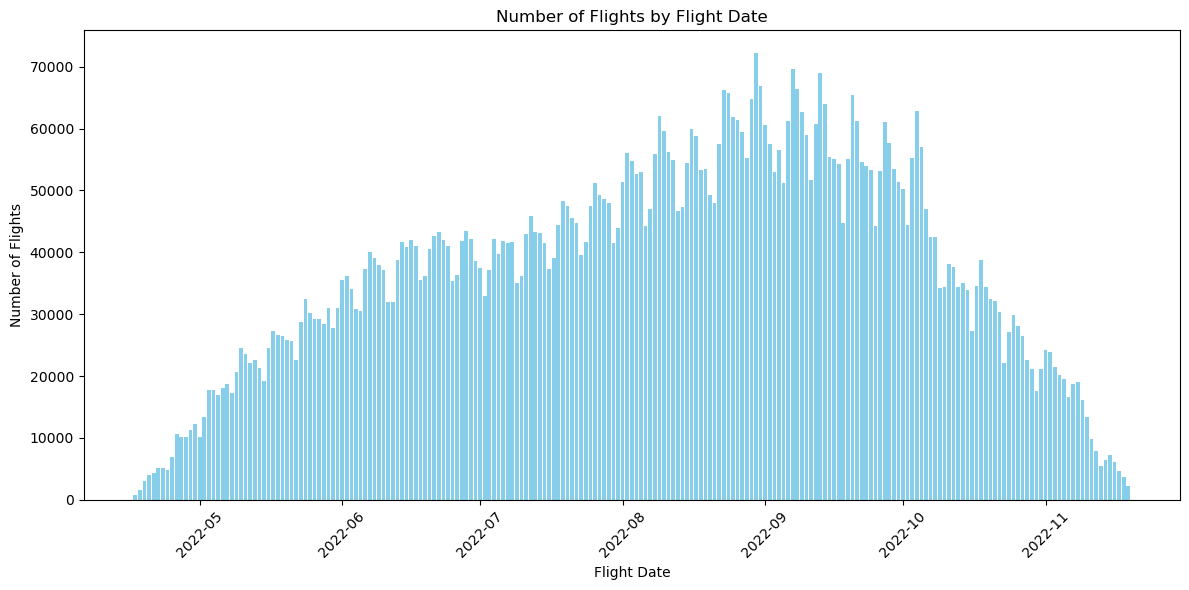

In [11]:
# Filter for flight dates from 2021 onwards
filtered_df = sampled_df.filter(year(col("flightDate")) >= 2021)

summary_df = filtered_df.groupBy("flightDate").agg(count("*").alias("flight_count")).orderBy("flightDate")

summary_pd = summary_df.toPandas()

plt.figure(figsize=(12, 6))
# Create a bar plot
plt.bar(summary_pd['flightDate'], summary_pd['flight_count'], color='skyblue')
# Set the x-axis and y-axis labels
plt.xlabel('Flight Date')
plt.ylabel('Number of Flights')
# Set the title
plt.title('Number of Flights by Flight Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("flight_count_by_date.png")
# Display the plot
plt.show()


In [12]:
unique_airlines_df = sampled_df.select("segmentsAirlineName").distinct()
unique_airlines_df.show(truncate=False)

unique_count = unique_airlines_df.count()
print(f"Number of unique airline names: {unique_count}")

+---------------------------------------------------------------------+
|segmentsAirlineName                                                  |
+---------------------------------------------------------------------+
|United||Alaska Airlines                                              |
|American Airlines||Southern Airways Express||Southern Airways Express|
|Boutique Air||Boutique Air||American Airlines                        |
|Delta||Cape Air||Cape Air||Delta                                     |
|Alaska Airlines||United||Delta                                       |
|Alaska Airlines||Alaska Airlines||United||United                     |
|United||Alaska Airlines||Alaska Airlines                             |
|Boutique Air||Boutique Air||United                                   |
|Southern Airways Express||Southern Airways Express||Alaska Airlines  |
|Delta                                                                |
|Alaska Airlines||Delta                                         

Number of unique airline names: 132


In [13]:
#Convert Boolean to binary numeric values  
sampled_df = sampled_df.withColumn("isBasicEconomy", col("isBasicEconomy").cast("double"))
sampled_df = sampled_df.withColumn("isRefundable", col("isRefundable").cast("double"))
sampled_df = sampled_df.withColumn("isNonStop", col("isNonStop").cast("double"))

In [14]:
sampled_df.printSchema()

root
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- isBasicEconomy: double (nullable = true)
 |-- isRefundable: double (nullable = true)
 |-- isNonStop: double (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- segmentsAirlineName: string (nullable = true)
 |-- segmentsCabinCode: string (nullable = true)
 |-- leadTime: integer (nullable = true)
 |-- flight_year: integer (nullable = true)
 |-- flight_month: integer (nullable = true)
 |-- flight_yearmonth: string (nullable = true)
 |-- flight_dayofweek: string (nullable = true)
 |-- flight_weekend: double (nullable = false)
 |-- day_of_week: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: int

In [15]:
sampled_df.show(10)


+----------+----------+---------------+------------------+-------------+--------------+------------+---------+--------+---------+--------------+--------------------+-------------------+--------+-----------+------------+----------------+----------------+--------------+-----------+------------+-----+----+----------+
|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining| segmentsAirlineName|  segmentsCabinCode|leadTime|flight_year|flight_month|flight_yearmonth|flight_dayofweek|flight_weekend|day_of_week|day_of_month|month|year|is_weekend|
+----------+----------+---------------+------------------+-------------+--------------+------------+---------+--------+---------+--------------+--------------------+-------------------+--------+-----------+------------+----------------+----------------+--------------+-----------+------------+-----+----+----------+
|2022-06-02|2022-06-21|            DFW|             

In [16]:
sampled_df.select(countDistinct("segmentsAirlineName")).show()
sampled_df.select(countDistinct("fareBasisCode")).show()
sampled_df.select(countDistinct("segmentsCabinCode")).show()
sampled_df.select(countDistinct("startingAirport")).show()
sampled_df.select(countDistinct("destinationAirport")).show()


+-----------------------------------+
|count(DISTINCT segmentsAirlineName)|
+-----------------------------------+
|                                132|
+-----------------------------------+



+-----------------------------+
|count(DISTINCT fareBasisCode)|
+-----------------------------+
|                        16383|
+-----------------------------+



+---------------------------------+
|count(DISTINCT segmentsCabinCode)|
+---------------------------------+
|                               30|
+---------------------------------+



+-------------------------------+
|count(DISTINCT startingAirport)|
+-------------------------------+
|                             16|
+-------------------------------+



+----------------------------------+
|count(DISTINCT destinationAirport)|
+----------------------------------+
|                                16|
+----------------------------------+



In [17]:
sampled_df.select("fareBasisCode").show(100, truncate=False)

+-------------+
|fareBasisCode|
+-------------+
|QAA0OKEN     |
|QAA0OKEN     |
|UAA0OKEN     |
|UAA0OKEN     |
|QAA0OKEN     |
|RA7NR        |
|TA3NA0ME     |
|SUAIZNN3     |
|QATNA0MC     |
|GUAIZNN1     |
|N3AGZNN1     |
|GUAJZNN3     |
|SAA0JHES     |
|G7AWZNN1     |
|G7AWZNN1     |
|D14GXP5      |
|VAA3JKEN     |
|QA0OA0MC     |
|M3AKZNN1     |
|GUAIZNN3     |
|KUAIZNN1     |
|KAUOA0MQ     |
|G3AJZNN3     |
|V3AJZNN1     |
|HAA0OKEN     |
|HAA0OKEN     |
|KA7QA0MQ     |
|XAUNX0BQ     |
|UAUQA0MQ     |
|GUAHZNN1     |
|UAUQA0MQ     |
|UAUQA0MQ     |
|UAUQA0MQ     |
|QA7QA0MQ     |
|PL7QUEL1     |
|WAA4JHES     |
|VUAHZNN1     |
|SAA4JFBN     |
|KAUOA0MQ     |
|EAA0KKEN     |
|OL7QUEY5     |
|PL7QUEL1     |
|MA0QA0MQ     |
|M3AIZNN1     |
|M3AIZNN1     |
|QAUOA0MQ     |
|M0AHZNN1     |
|SUAHZNN3     |
|GUAJZNN1     |
|BUAHZNN1     |
|TAUQA0BQ     |
|SAA4JHES     |
|M7AHZNN1     |
|EAA0OFEN     |
|KH0OASMN     |
|BA7OA0MQ     |
|UAA0OFEN     |
|UAA0OFEN     |
|UAA0OFEN     |
|QAA3JHE

In [18]:
# Categorical columns and their corresponding output index/vector columns
categorical_cols = ["startingAirport", "destinationAirport", "segmentsAirlineName", "segmentsCabinCode"]
categorical_index_cols = [f"{col}Index" for col in categorical_cols]
categorical_vector_cols = [f"{col}Vector" for col in categorical_cols]

# Numeric columns (no transformation needed)
numeric_cols = ["leadTime", "baseFare", "seatsRemaining"]

# Boolean columns (no transformation needed, assuming they're already numeric 0/1)
boolean_cols = ["isBasicEconomy", "isRefundable", "isNonStop"]


In [19]:
# Define StringIndexer with handleInvalid="keep"
indexer = StringIndexer(
    inputCols=["startingAirport", "destinationAirport", "segmentsAirlineName", "segmentsCabinCode"],
    outputCols=["startingAirportIndex", "destinationAirportIndex", "segmentsAirlineNameIndex", "segmentsCabinCodeIndex"],
    handleInvalid="keep"
)

# Define OneHotEncoder
encoder = OneHotEncoder(
    inputCols=["startingAirportIndex", "destinationAirportIndex", "segmentsAirlineNameIndex", "segmentsCabinCodeIndex"],
    outputCols=["startingAirportVector", "destinationAirportVector", "segmentsAirlineNameVector", "segmentsCabinCodeVector"],
    dropLast=True
)

# Define VectorAssembler
assembler = VectorAssembler(
    inputCols=["startingAirportVector", "destinationAirportVector", "segmentsAirlineNameVector", 
               "segmentsCabinCodeVector", "leadTime", "baseFare", "seatsRemaining", 
               "isBasicEconomy", "isRefundable", "isNonStop"],
    outputCol="features"
)

In [20]:
# Create a Linear Regression Estimator
linear_reg = LinearRegression(labelCol='totalFare',  elasticNetParam=0, regParam=0.1)

In [21]:
# Create the pipeline
regression_pipe = Pipeline(stages=[indexer, encoder, assembler,linear_reg])

In [23]:
# Create a grid to hold hyperparameters 
grid = ParamGridBuilder()

# Build the parameter grid
grid = grid.build()

# Create the CrossValidator using the hyperparameter grid
cv = CrossValidator(estimator=regression_pipe, 
                    estimatorParamMaps=grid, 
                    evaluator=evaluator, 
                    numFolds=3)


In [24]:
# Create a regression evaluator (to get RMSE, R2, RME, etc.)
evaluator = RegressionEvaluator(labelCol="totalFare")
cv = CrossValidator(estimator=regression_pipe, estimatorParamMaps=grid, evaluator=evaluator, numFolds=3)

In [25]:
# Fit the feature pipeline on training data
feature_pipeline_model = regression_pipe.fit(sampled_df)

# Transform the data to include features
transformed_data = feature_pipeline_model.transform(sampled_df)

# Split the data into training and test sets
trainingData, testData = sampled_df.randomSplit([0.70, 0.3], seed=42)


# Save the transformed data with features
trust_file_path = 'gs://my-bigdata-project-lh/trusted/trusted_data.parquet'
transformed_data.select("features", "totalFare").write.parquet(trust_file_path, mode="overwrite")


In [26]:
# Train the models
all_models  = cv.fit(trainingData)

# Show the average performance over the three folds
print(f"Average metric {all_models.avgMetrics}")

Average metric [6.415799355500069]


In [27]:
# Get the best model from all of the models trained
bestModel = all_models.bestModel

# Save the best model to the /models folder
bestModel.write().overwrite().save("gs://my-bigdata-project-lh/models/best_model")

# Use the model 'bestModel' to predict the test set
test_results = bestModel.transform(testData)

In [28]:
# Show the predicted ticket price 
test_results.select('startingAirport','destinationAirport','segmentsAirlineName','segmentsCabinCode','leadTime','baseFare', 'seatsRemaining','isBasicEconomy', 'isRefundable', 'isNonStop', 'totalFare', 'prediction').show(truncate=False)
# Calculate RMSE and R2
rmse = evaluator.evaluate(test_results, {evaluator.metricName:'rmse'})
r2 =evaluator.evaluate(test_results,{evaluator.metricName:'r2'})
print(f"RMSE: {rmse}  R-squared:{r2}")

+---------------+------------------+------------------------------------+-----------------+--------+--------+--------------+--------------+------------+---------+---------+------------------+
|startingAirport|destinationAirport|segmentsAirlineName                 |segmentsCabinCode|leadTime|baseFare|seatsRemaining|isBasicEconomy|isRefundable|isNonStop|totalFare|prediction        |
+---------------+------------------+------------------------------------+-----------------+--------+--------+--------------+--------------+------------+---------+---------+------------------+
|DEN            |CLT               |United||United                      |coach||coach     |11      |296.74  |3             |0.0           |0.0         |0.0      |342.6    |343.49599515288304|
|DEN            |DFW               |Delta||Delta                        |coach||coach     |11      |120.0   |9             |1.0           |0.0         |0.0      |152.6    |153.6992385601224 |
|DEN            |DFW               |Amer

RMSE: 6.386835388430065  R-squared:0.9985219724965967


In [29]:
test_results.printSchema()

root
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- isBasicEconomy: double (nullable = true)
 |-- isRefundable: double (nullable = true)
 |-- isNonStop: double (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- segmentsAirlineName: string (nullable = true)
 |-- segmentsCabinCode: string (nullable = true)
 |-- leadTime: integer (nullable = true)
 |-- flight_year: integer (nullable = true)
 |-- flight_month: integer (nullable = true)
 |-- flight_yearmonth: string (nullable = true)
 |-- flight_dayofweek: string (nullable = true)
 |-- flight_weekend: double (nullable = false)
 |-- day_of_week: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: int

In [30]:
# Define the output folder in Google Cloud Storage
output_folder = "gs://my-bigdata-project-lh/results/test_results"

# Select only primitive-type columns (exclude vectors and complex types)
columns_to_save = [
    "startingAirport", "destinationAirport", "segmentsAirlineName",
    "segmentsCabinCode", "leadTime", "baseFare", "seatsRemaining",
    "isBasicEconomy", "isRefundable", "isNonStop", "totalFare", "prediction"
]

# Write the selected columns to CSV
test_results.select(*columns_to_save).write.csv(output_folder, mode="overwrite", header=True)

print(f"Test results saved to: {output_folder}")

Test results saved to: gs://my-bigdata-project-lh/results/test_results


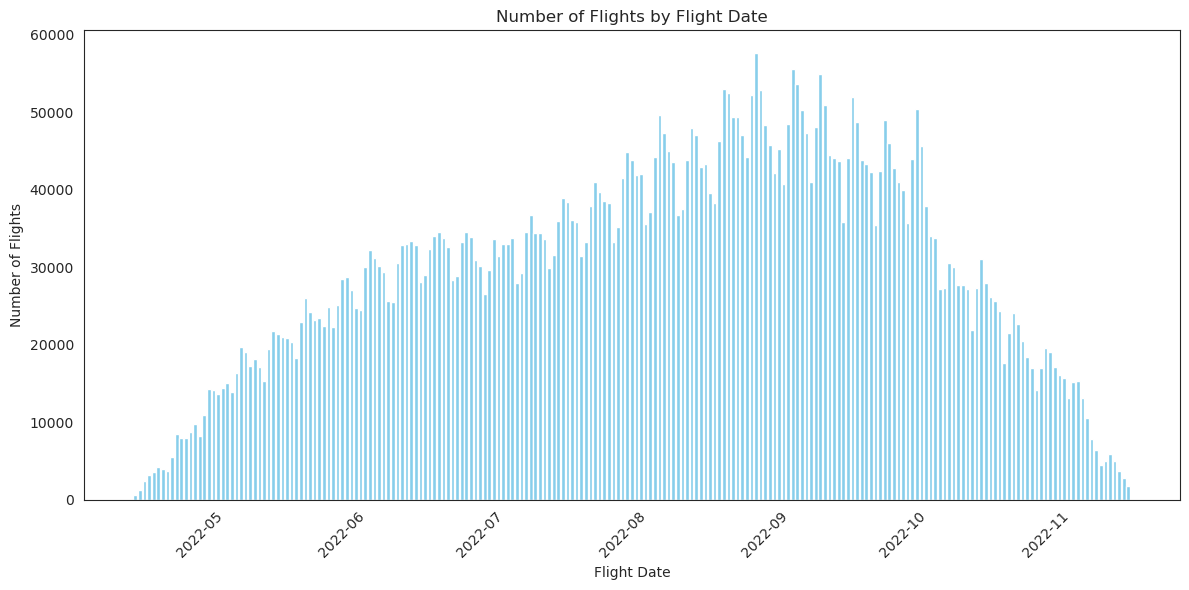

In [42]:
sample_df = cleaned_df.sample(withReplacement=False, fraction=0.08)

summary_sdf = sample_df.filter(year(col("flightDate")) == 2022)

summary_df = summary_sdf.groupBy("flightDate").agg(count("*").alias("flight_count")).orderBy("flightDate")

summary_pd = summary_df.toPandas()

plt.figure(figsize=(12, 6))
# Create a bar plot
plt.bar(summary_pd['flightDate'], summary_pd['flight_count'], color='skyblue')
# Set the x-axis and y-axis labels
plt.xlabel('Flight Date')
plt.ylabel('Number of Flights')
# Set the title
plt.title('Number of Flights by Flight Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("flight_count_by_date.png")
# Display the plot
plt.show()

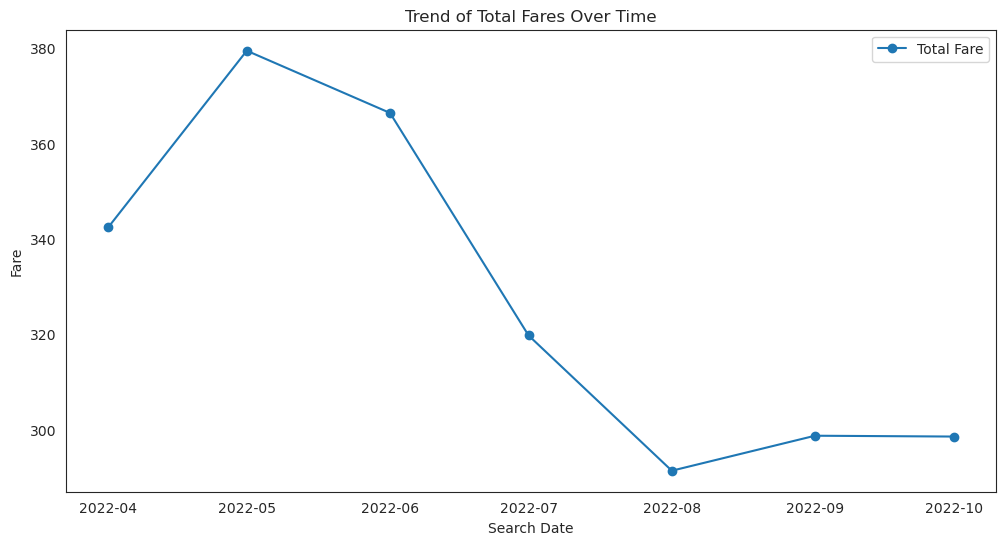

In [43]:
filtered_df = filtered_df.withColumn("searchDate", to_date(col("searchDate")))

# Filter flights with flightDate >= 2021
filtered_df = sampled_df.filter(year(col("flightDate")) >= 2021)

# Group by 'searchDate' and calculate mean of 'baseFare' and 'totalFare'
fare_trend = filtered_df.groupBy(date_trunc("month", col("searchDate")).alias("month")).agg(
    avg("totalFare").alias("avgTotalFare")
)

# Convert PySpark DataFrame to Pandas DataFrame for visualization
df = fare_trend.toPandas()

df.rename(columns={"month": "searchDate"}, inplace=True)

df.set_index("searchDate", inplace=True)
df = df.asfreq("MS")  # Monthly frequency
df.reset_index(inplace=True)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df["searchDate"], df["avgTotalFare"], label="Total Fare", marker="o")
plt.xlabel("Search Date")
plt.ylabel("Fare")
plt.title("Trend of Total Fares Over Time")
plt.legend()
plt.show()

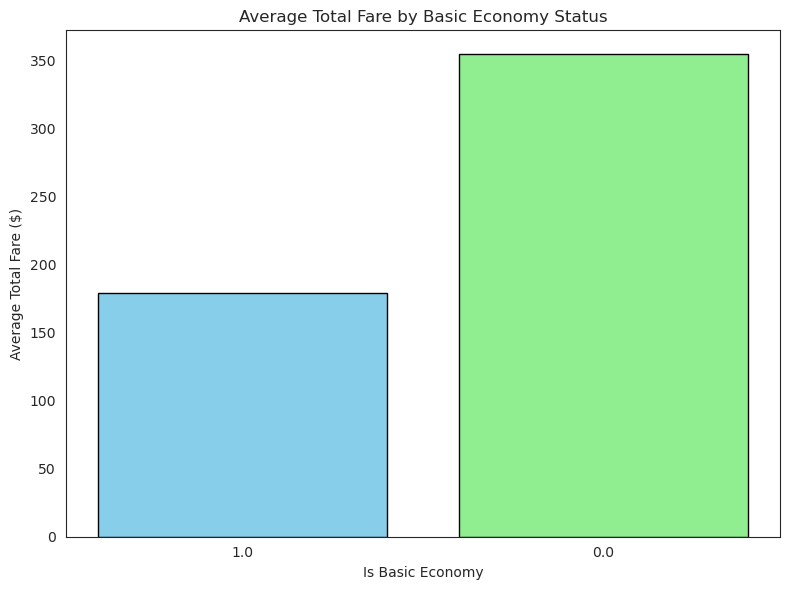

In [44]:
from pyspark.sql.functions import sum as spark_sum, col

# Cast boolean columns to integer and sum them
basic_economy_fare = filtered_df.groupBy("isBasicEconomy").agg(
    avg("totalFare").alias("avgTotalFare")
)
# Convert to Pandas for visualization
basic_economy_fare_pd = basic_economy_fare.toPandas()

plt.figure(figsize=(8, 6))
plt.bar(
    basic_economy_fare_pd["isBasicEconomy"].astype(str),  # Convert boolean to string for better labels
    basic_economy_fare_pd["avgTotalFare"],
    color=["skyblue", "lightgreen"],
    edgecolor="black"
)
plt.title("Average Total Fare by Basic Economy Status")
plt.xlabel("Is Basic Economy")
plt.ylabel("Average Total Fare ($)")
plt.tight_layout()
plt.show()

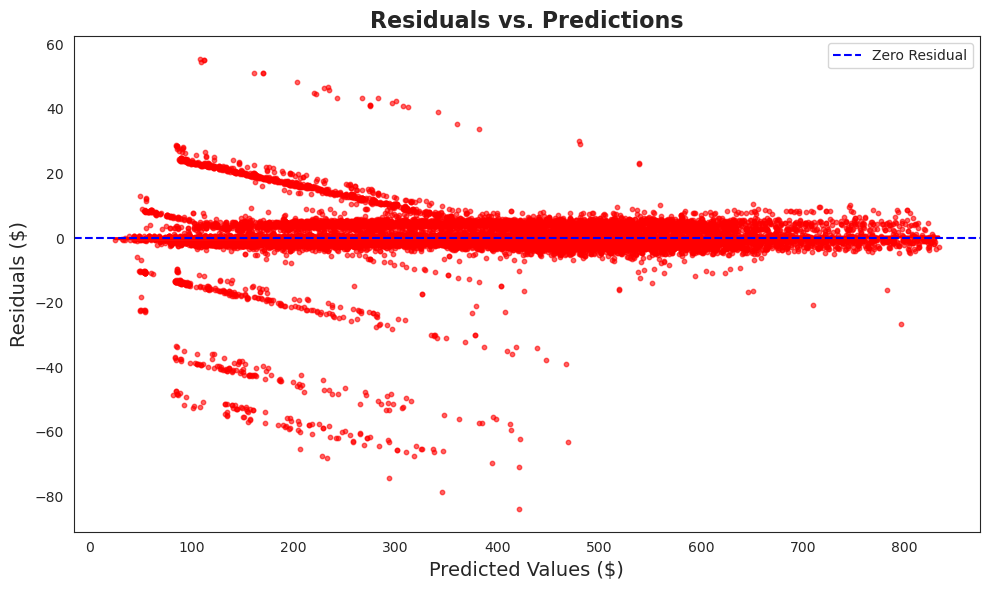

In [46]:
import seaborn as sns

df = test_results.select('totalFare', 'prediction').sample(False, 0.01).toPandas()
df['residuals'] = df['totalFare'] - df['prediction']

# Set the style for Seaborn plots
sns.set_style("white")

plt.figure(figsize=(10, 6))
sns.regplot(x='prediction', y='residuals', data=df, scatter_kws={'alpha': 0.6, 's': 10}, color='red')

# Add titles and labels
plt.title("Residuals vs. Predictions", fontsize=16, weight='bold')
plt.xlabel("Predicted Values ($)", fontsize=14)
plt.ylabel("Residuals ($)", fontsize=14)

# Add a horizontal line at y=0 to highlight where residuals should ideally lie
plt.axhline(0, color='blue', linestyle='--', linewidth=1.5, label='Zero Residual')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

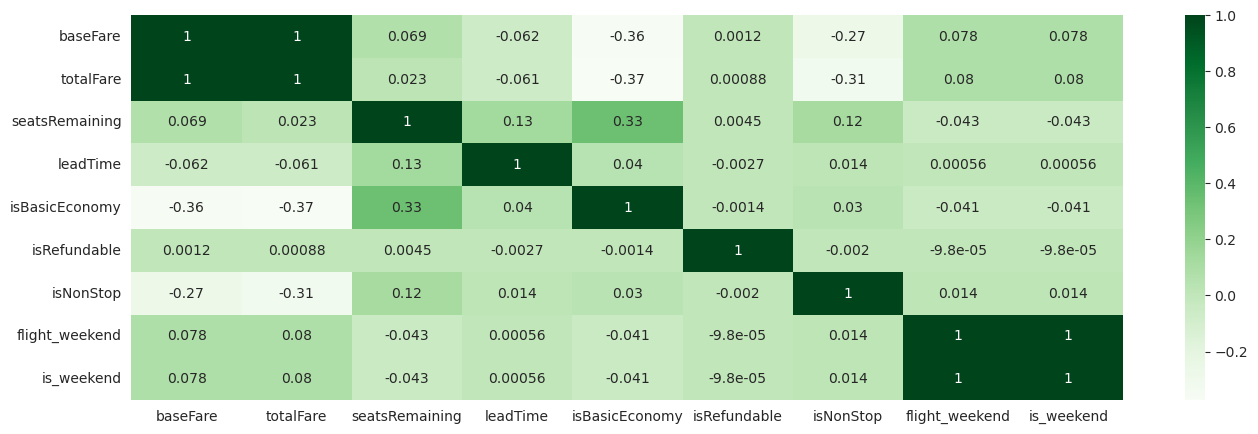

In [51]:
from pyspark.ml.stat import Correlation

#Correlation Matrix using Seaborn
vector_column = "correlation_features"
#Choose the numeric columns
numeric_columns = ['baseFare', 'totalFare', 'seatsRemaining', 'leadTime', 'isBasicEconomy', 
                   'isRefundable', 'isNonStop', 'flight_weekend', 'is_weekend']
assembler = VectorAssembler(inputCols=numeric_columns, outputCol=vector_column)
sdf_vector = assembler.transform(sampled_df).select(vector_column)

#Create the correlation Matrix, then get just the values and convert to a list
matrix = Correlation.corr(sdf_vector,vector_column).collect()[0][0]
correlation_matrix = matrix.toArray().tolist()

#Convert the correlation to a Pandas dataframe
correlation_matrix_df = pd.DataFrame(data=correlation_matrix, columns = numeric_columns, index = numeric_columns)

heatmap_plot = plt.figure(figsize =(16, 5))

# Set the style for Seaborn plots
sns.set_style("white")

sns.heatmap(correlation_matrix_df,
            xticklabels=correlation_matrix_df.columns.values,
            yticklabels=correlation_matrix_df.columns.values,  cmap="Greens", annot=True)
plt.savefig("correlation_matrix.png")